In [ ]:
import umap
!pip install umap-learn[plot] kneed
import umap.plot
from umap import UMAP

import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from kneed import KneeLocator
from collections import Counter
from sklearn import decomposition
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

In [ ]:
mnist = sklearn.datasets.fetch_openml('mnist_784')

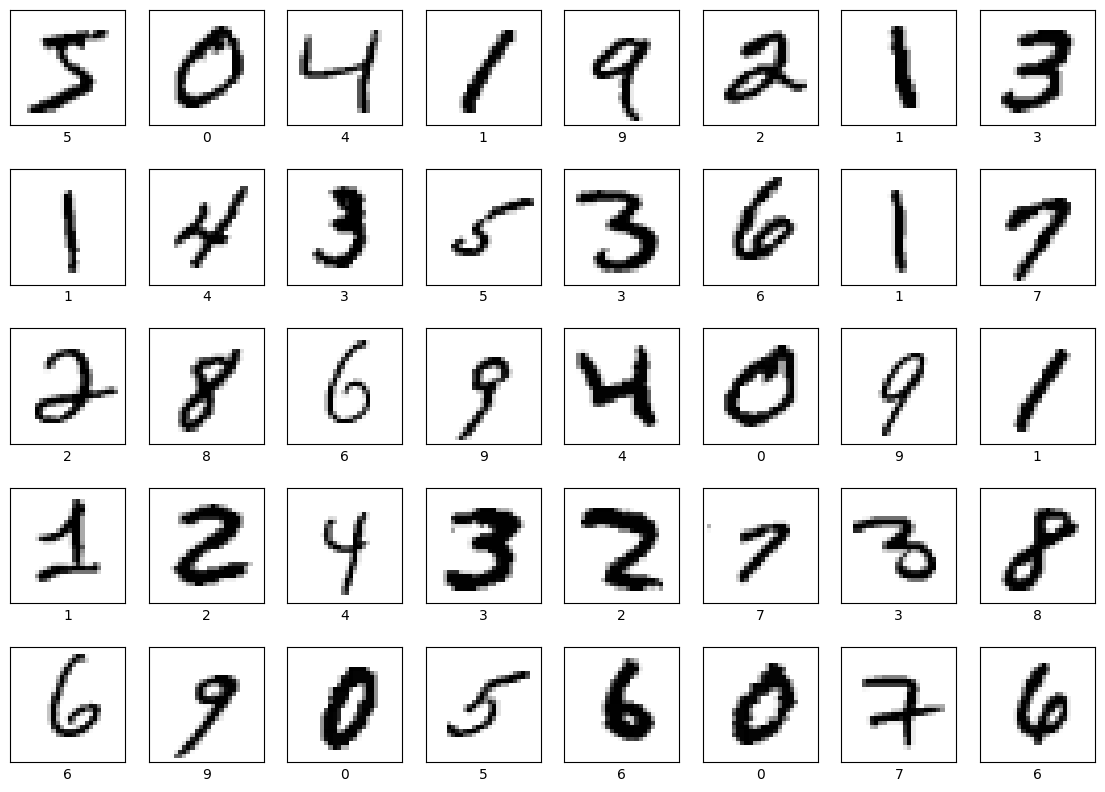

In [ ]:
mnist_names = [i for i in range(10)]

plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(mnist.data.iloc[i]).reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

In [ ]:
print(f"Исходный размер датасета: {len(mnist.data)} изображений")

# Определение размера выборки (10% от исходного)
sample_size = int(len(mnist.data) * 0.1)

# Случайное сэмплирование
np.random.seed(5)
random_indices = np.random.permutation(len(mnist.data))[:sample_size]
mnist.data, mnist.target = mnist.data.iloc[random_indices], mnist.target.iloc[random_indices]

# Размер сэмплированного датасета
print(f"Размер сэмплированного датасета: {len(mnist.data)} изображений")

Исходный размер датасета: 70000 изображений
Размер сэмплированного датасета: 7000 изображений


In [ ]:
df_mnist = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
df_mnist['target'] = mnist.target

In [ ]:
print(f"Mnist dataset shape: {df_mnist.shape}")
X_mnist_data = df_mnist.iloc[:, :-1].values / 255.0
y_mnist_data = df_mnist.loc[:, 'target'].values

Mnist dataset shape: (7000, 785)


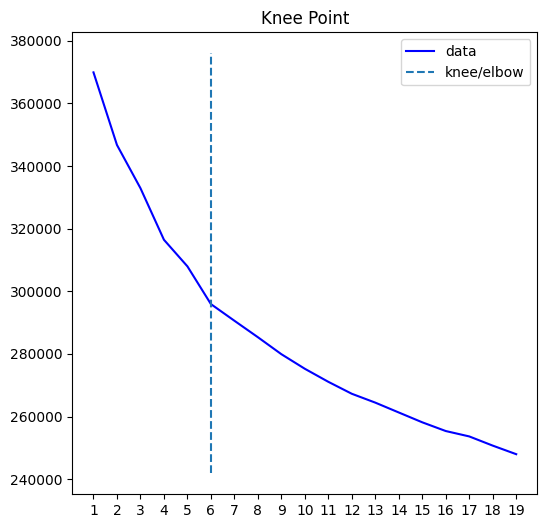

'clusters = Counter({5: 1375, 0: 1335, 2: 1319, 4: 1201, 1: 1153, 3: 617})'

In [ ]:
distortions = []
k = range(1, 20)

for kInd in k:
  kmeanModel = KMeans(n_clusters=kInd)
  kmeanModel.fit(X_mnist_data)
  # Сумма квадратов расстояний выборок до их ближайшего центра кластера
  distortions.append(kmeanModel.inertia_)

kneeLocator = KneeLocator(k, distortions, curve="convex", direction="decreasing")

kneeLocator.plot_knee()
plt.xticks(np.arange(min(k), max(k) + 1, 1.0))
plt.show()

kmeanModel = KMeans(n_clusters=kneeLocator.knee)
kmeans_labels = kmeanModel.fit_predict(X_mnist_data)

display(f"clusters = {Counter(kmeans_labels)}")

'knee = 5.826785911960521'

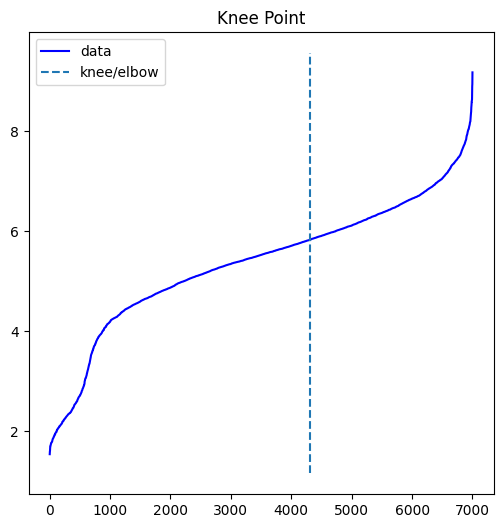

'clusters = Counter({0: 4273, -1: 2692, 1: 10, 2: 10, 4: 8, 3: 7})'

In [ ]:
neighbors = NearestNeighbors().fit(X_mnist_data)
neighborsDist, neighborsInd = neighbors.kneighbors(X_mnist_data)
sortNeighborDist = np.sort(neighborsDist, axis=0)

x = range(1, len(neighborsDist) + 1)
y = sortNeighborDist[:, 3]

kneeLocator = KneeLocator(x, y, curve="convex", S=35)
knee = kneeLocator.knee_y
display(f"knee = {knee}")

kneeLocator.plot_knee()
plt.show()

dbscan_labels = DBSCAN(eps=knee, min_samples=10).fit_predict(X_mnist_data)
display(f"clusters = {Counter(dbscan_labels)}")

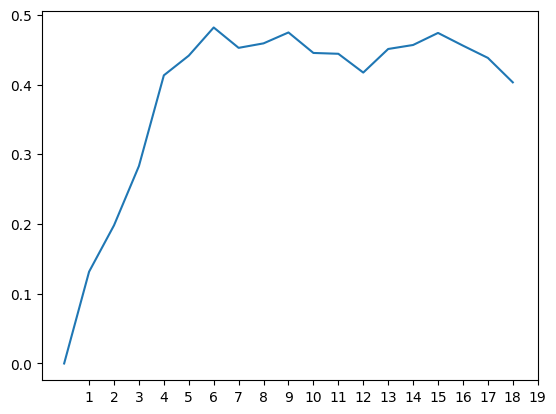

clusters count 7


'clusters = Counter({3: 1808, 1: 1803, 0: 731, 4: 700, 2: 694, 5: 634, 6: 630})'

In [ ]:
ari = []
k = range(1, 20)

for kInd in k:
  model = AgglomerativeClustering(n_clusters=kInd)
  model.fit(X_mnist_data)
  # ARI score
  ari.append(adjusted_rand_score(y_mnist_data.astype(int), model.labels_))

plt.plot(ari)
plt.xticks(np.arange(min(k), max(k) + 1, 1.0))
plt.show()

n_clusters = np.argmax(ari) + 1
print(f"clusters count {n_clusters}")

agglomerative_labels = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X_mnist_data)
counter = Counter(agglomerative_labels)
display(f"clusters = {counter}")

In [ ]:
def plot_2d_mnist_scatter(title, X, y_orig, y_kmeans, y_dbscan, y_agglomerative):
    fig, plots = plt.subplots(2, 2)
    fig.set_size_inches(9, 9)
    fig.suptitle(title)
    plt.prism()

    for i in range(len(Counter(y_orig))):
        digit_indices = (y_orig == i)
        dim0 = X[digit_indices, 0]
        dim1 = X[digit_indices, 1]
        plots[0, 0].set_title('Original')
        plots[0, 0].scatter(dim0, dim1, label=f"Digit {i}")
        plots[0, 0].legend()

    for i in range(len(Counter(y_kmeans))):
        digit_indices = (y_kmeans == i)
        dim0 = X[digit_indices, 0]
        dim1 = X[digit_indices, 1]
        plots[0, 1].set_title('K-Means')
        plots[0, 1].scatter(dim0, dim1)

    for i in range(len(Counter(y_dbscan))):
        digit_indices = (y_dbscan == i)
        dim0 = X[digit_indices, 0]
        dim1 = X[digit_indices, 1]
        plots[1, 0].set_title('DBSCAN')
        plots[1, 0].scatter(dim0, dim1)

    for i in range(len(Counter(y_agglomerative))):
        digit_indices = (y_agglomerative == i)
        dim0 = X[digit_indices, 0]
        dim1 = X[digit_indices, 1]
        plots[1, 1].set_title('Agglomerative')
        plots[1, 1].scatter(dim0, dim1)

    plt.tight_layout()
    plt.legend()
    plt.show()

<ipython-input-10-7035dee10d04>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


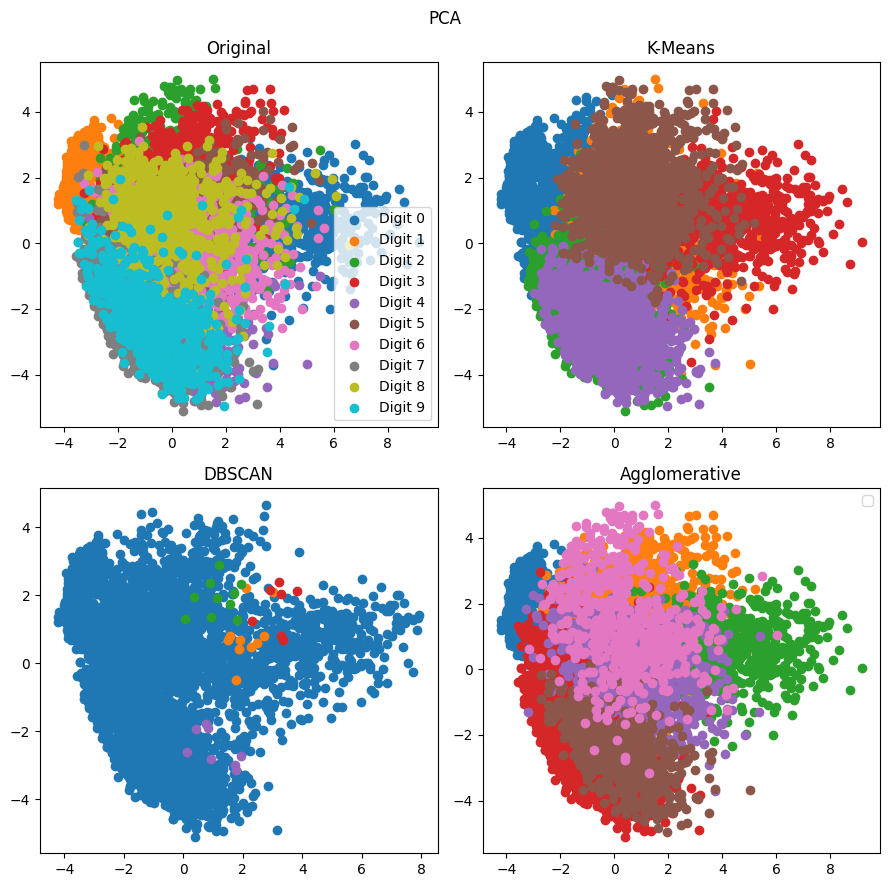

In [ ]:
mnist_pca_embedding = decomposition.PCA(n_components=2).fit_transform(X_mnist_data)
plot_2d_mnist_scatter('PCA', mnist_pca_embedding, y_mnist_data.astype(int), kmeans_labels, dbscan_labels, agglomerative_labels)

In [ ]:
mnist_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(X_mnist_data)

<ipython-input-10-7035dee10d04>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


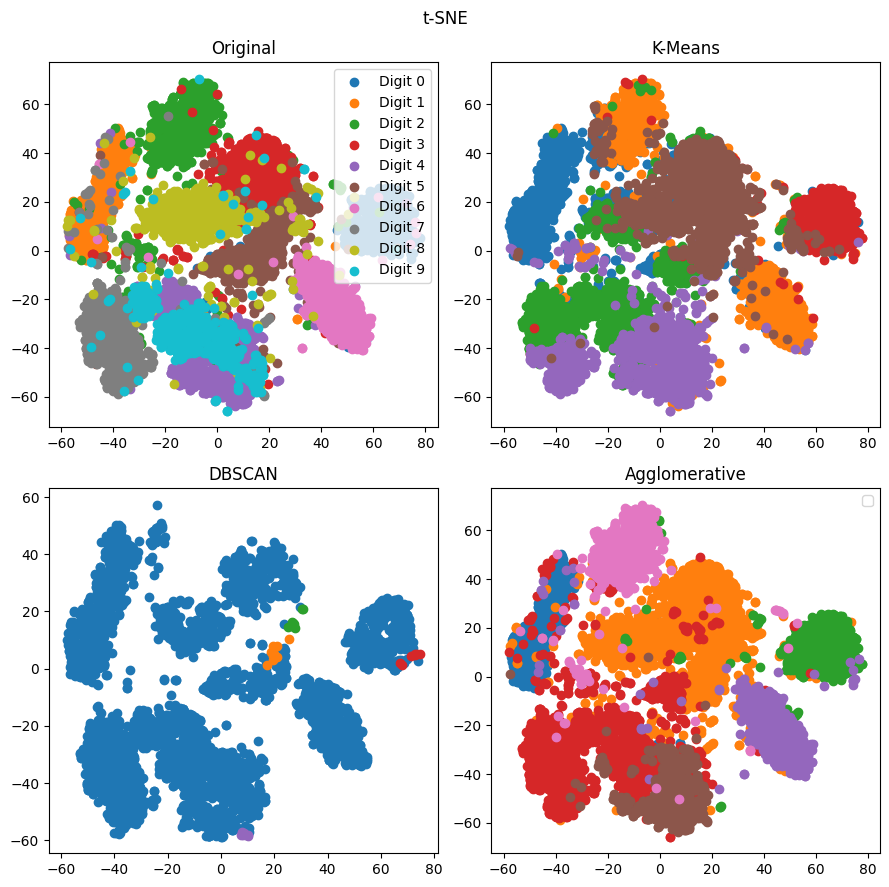

In [ ]:
plot_2d_mnist_scatter('t-SNE', mnist_tsne_embedding, y_mnist_data.astype(int), kmeans_labels, dbscan_labels, agglomerative_labels)

In [ ]:
mnist_umap_reducer = UMAP()
mnist_umap_embedding = mnist_umap_reducer.fit_transform(X_mnist_data)
mnist_umap_embedding.shape

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(7000, 2)

<ipython-input-10-7035dee10d04>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


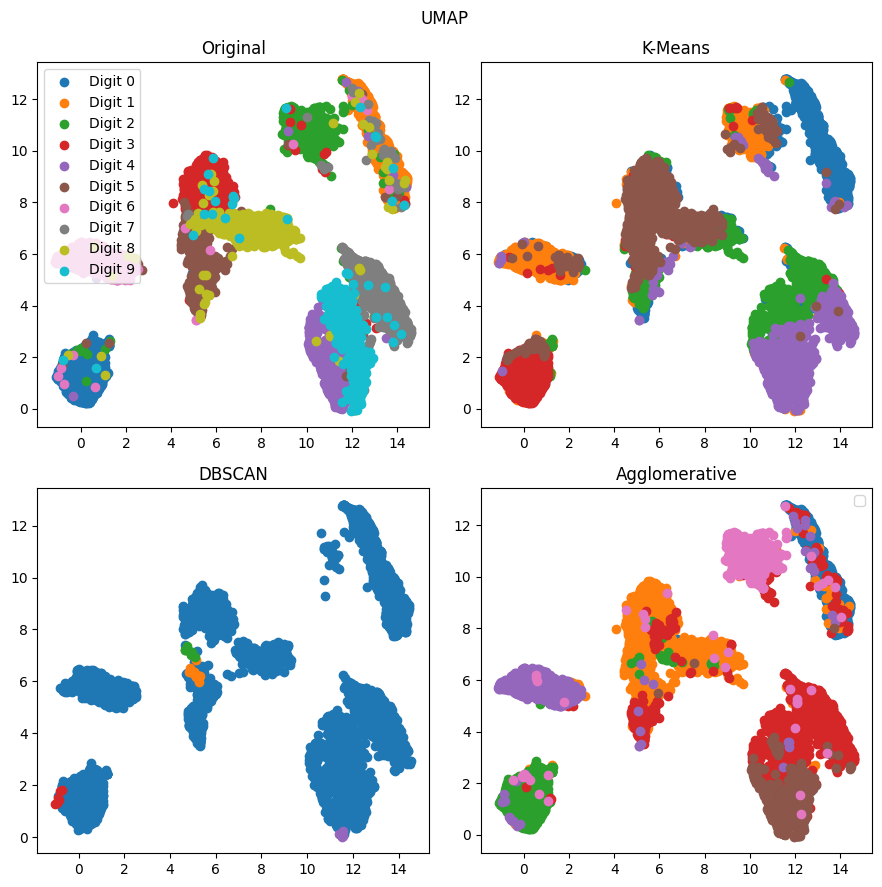

In [ ]:
plot_2d_mnist_scatter('UMAP', mnist_umap_embedding, y_mnist_data.astype(int), kmeans_labels, dbscan_labels, agglomerative_labels)